In [1]:
# !pip install yfinance
# !pip install tsai

In [2]:
from tsai.basics import *
import yfinance as yf

In [3]:
interval = "1d"
start_date = "2004-08-19"
val_date = "2020-05-01"
test_date = "2022-05-01"
end_date = "2024-05-11"

# Calculate number of intervals
valid_size = 504
test_size = 509

print("Valid Size:", valid_size)
print("Test Size:", test_size)

gspc = yf.Ticker("^GSPC")
gspc_hist = gspc.history(start=start_date, end=end_date, interval=interval)

gspc_hist['Close']

Valid Size: 504
Test Size: 509


Date
2004-08-19 00:00:00-04:00    1091.229980
2004-08-20 00:00:00-04:00    1098.349976
2004-08-23 00:00:00-04:00    1095.680054
2004-08-24 00:00:00-04:00    1096.189941
2004-08-25 00:00:00-04:00    1104.959961
                                ...     
2024-05-06 00:00:00-04:00    5180.740234
2024-05-07 00:00:00-04:00    5187.700195
2024-05-08 00:00:00-04:00    5187.669922
2024-05-09 00:00:00-04:00    5214.080078
2024-05-10 00:00:00-04:00    5222.680176
Name: Close, Length: 4966, dtype: float64

In [5]:
ts = gspc_hist['Close'].values
ts

array([1091.22998047, 1098.34997559, 1095.68005371, ..., 5187.66992188,
       5214.08007812, 5222.68017578])

In [6]:
from tsai.inference import load_learner
def predict(fcst, X, y, split):
    raw_preds, target, preds = fcst.get_X_preds(X[split], y[split])
    
    return pd.DataFrame({"raw_preds": raw_preds.flatten(), "target": target, "preds": preds})

In [7]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def MASE(pred, y):
    return float(np.mean(np.abs(pred - y) / np.mean(np.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    return float(200 * np.mean(np.abs(pred - y) / (np.abs(y) + np.abs(pred))))

def MAE(pred, y):
    return float(np.mean(np.abs(pred - y)))

def sharp_ratio(pred, y):
    return float(np.mean((pred - y) / np.std(y)))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

def evaluate(y_true, y_pred, to_df=False, save=False, model_name="model_name"):
    performance = {}
    performance['MSE'] = mean_squared_error(y_true, y_pred)
    performance['MAPE'] = MAPE(y_true, y_pred)
    performance['MASE'] = MASE(y_true, y_pred)
    performance['RMSE'] = math.sqrt(mean_squared_error(y_true, y_pred))
    performance['SMAPE'] = SMAPE(y_true, y_pred)
    performance['MAE'] = MAE(y_true, y_pred)
    performance['SHAPE'] = sharp_ratio(y_true, y_pred)
    performance['Directional Accuracy'] = directional_accuracy(y_true, y_pred)

    if save:
        pd.DataFrame(performance, index=[model_name]).to_csv(f'../performance/{model_name}.csv')
    
    if to_df:
        performance = pd.DataFrame(performance, index=range(1))
    
    return performance


In [8]:
archs = [
    "LSTM",
    "GRU",
    "MLP",
    "FCN",
    "ResNet",
    "LSTM_FCN",
    "GRU_FCN",
    "mWDN",
    "TCN",
    "MLSTM_FCN",
    "InceptionTime",
    "XceptionTime",
    "ResCNN",
    "OmniScaleCNN",
    "TST",
    "TSTPlus",
    "TSiT",
    "MiniRocket",
    "XCM",
    "gMLP",
    "TSSequencerPlus",
]

wandb: Currently logged in as: gri11. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: jerk0kfk
Sweep URL: https://wandb.ai/gri11/stonk/sweeps/jerk0kfk


wandb: Agent Starting Run: yl3ln0qg with config:
wandb: 	arch: TSSequencerPlus
wandb: 	lr: 0.001
wandb: 	num_epoch: 114
wandb: 	window_len: 340
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


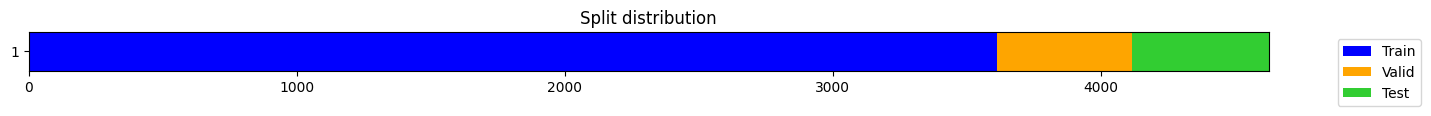

epoch,train_loss,valid_loss,mae,time
0,3579219.000000,16174620.000000,3986.683594,00:09
1,3574199.500000,16170535.000000,3986.168457,00:09
2,3570129.500000,16165858.000000,3985.578125,00:09
3,3568055.500000,16159341.000000,3984.751465,00:09
4,3566943.000000,16149011.000000,3983.450195,00:09
5,3565030.500000,16141168.000000,3982.461670,00:09


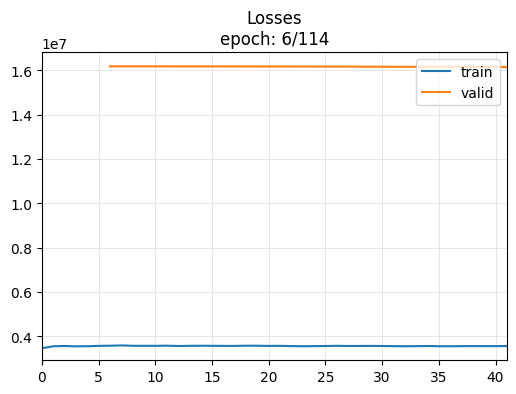

wandb: Ctrl + C detected. Stopping sweep.


AttributeError: 'NoneType' object has no attribute 'keys'

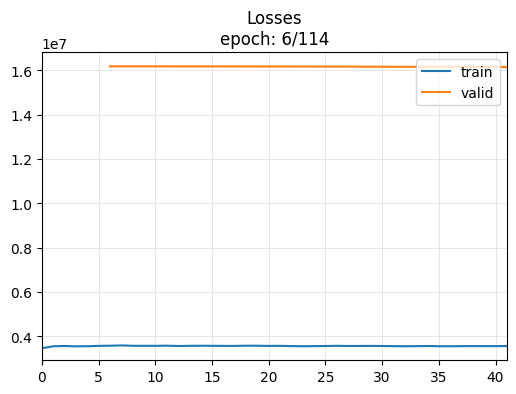

In [9]:
from tsai.wandb import wandb_agent
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")
wandb.login(key=secret_value_0)

# 1: Define objective/training function
def objective(config):
    score = config.x**3 + config.y
    return score

def main():
    wandb.init(project="my-first-sweep")
    score = objective(wandb.config)
    wandb.log({"score": score})

def train():
    wandb.init(project="stonk")
    window_len = wandb.config.window_len
    X, y = SlidingWindow(window_len, horizon=1)(ts)
    splits = TimeSplitter(valid_size=valid_size, test_size=test_size)(y)
    tfms = [None, TSForecasting()]
    batch_tfms = TSStandardize()
    fcst = TSForecaster(X, y, splits=splits, path='models/', tfms=tfms, batch_tfms=batch_tfms, bs=512, 
                        arch=wandb.config.arch, metrics=mae, cbs=ShowGraph())
    fcst.fit_one_cycle(wandb.config.num_epoch, wandb.config.lr)
    
    results = {
        "train": predict(fcst, X, y, splits[0]),
        "val": predict(fcst, X, y, splits[1]),
        "test": predict(fcst, X, y, splits[2]),
    }
    
    performance = evaluate(results['val']['target'], results['val']['raw_preds'])
    
    wandb.log(performance)
    
    fcst.export(f"{wandb.config.arch}_{wandb.config.window_len}.pkl")

# 2: Define the search space
sweep_configuration = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "mae"},
    "parameters": {
        "arch": {"values": archs},
        "window_len": {"max": 512, "min": 120},
        "num_epoch": {"max": 200, "min": 50},
#         "num_epoch": {"max": 3, "min": 1},
        "lr": {"values": [1e-3]},
    },
}

# 3: Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="stonk")
sweep = wandb.agent(sweep_id, function=train, count=10)

wandb_agent(None, sweep)

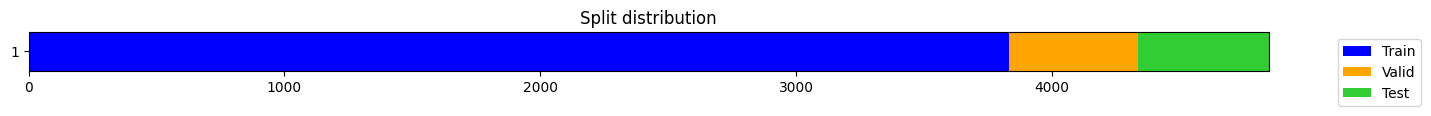

In [10]:
window_len = 120
X, y = SlidingWindow(window_len, horizon=1)(ts)
splits = TimeSplitter(valid_size=valid_size, test_size=test_size)(y)

InceptionTime


epoch,train_loss,valid_loss,mae,time
0,3437190.750000,16175951.000000,3986.861328,00:01
1,3436862.250000,16149182.000000,3983.629639,00:01
2,3444092.250000,16090228.000000,3976.507324,00:01
3,3441537.250000,16078776.000000,3975.070557,00:01
4,3444649.250000,16061098.000000,3972.898193,00:01
5,3440805.500000,16050027.000000,3971.508057,00:01
6,3437547.000000,16047454.000000,3971.194336,00:01
7,3434996.500000,16037949.000000,3970.011230,00:01
8,3433308.750000,16036885.000000,3969.867676,00:01
9,3433123.000000,16033346.000000,3969.434814,00:01


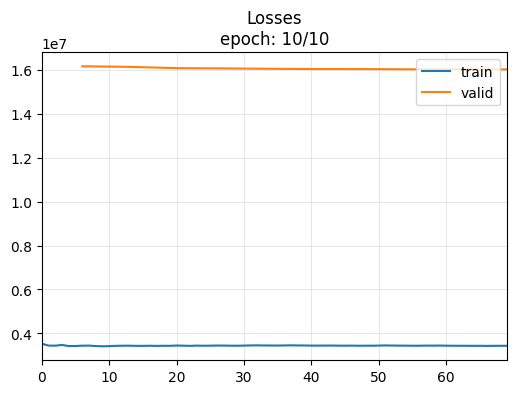

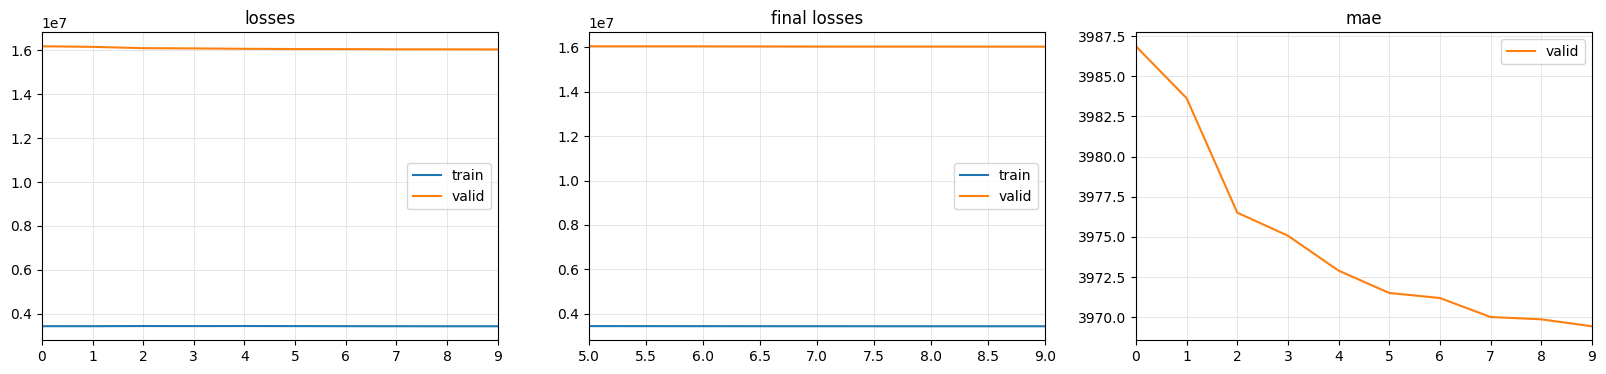

XceptionTime


epoch,train_loss,valid_loss,mae,time
0,3455611.500000,16169555.000000,3986.067627,00:00
1,3450904.000000,16163172.000000,3985.289795,00:00
2,3444091.500000,16161850.000000,3985.117920,00:00
3,3443464.250000,16162864.000000,3985.240479,00:00
4,3442704.250000,16161218.000000,3985.044922,00:00
5,3444301.500000,16163041.000000,3985.265869,00:00
6,3448487.500000,16160294.000000,3984.936279,00:00
7,3447547.750000,16162432.000000,3985.187256,00:00
8,3448867.500000,16161866.000000,3985.115234,00:00
9,3450091.000000,16162827.000000,3985.222656,00:00


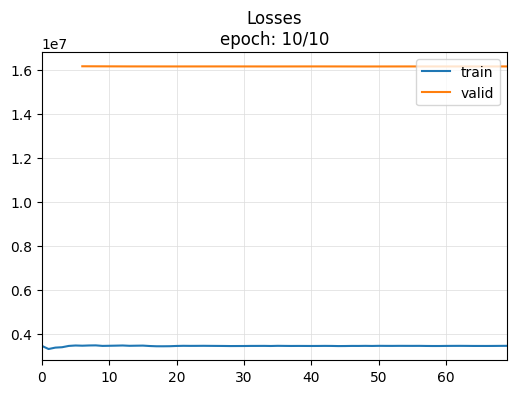

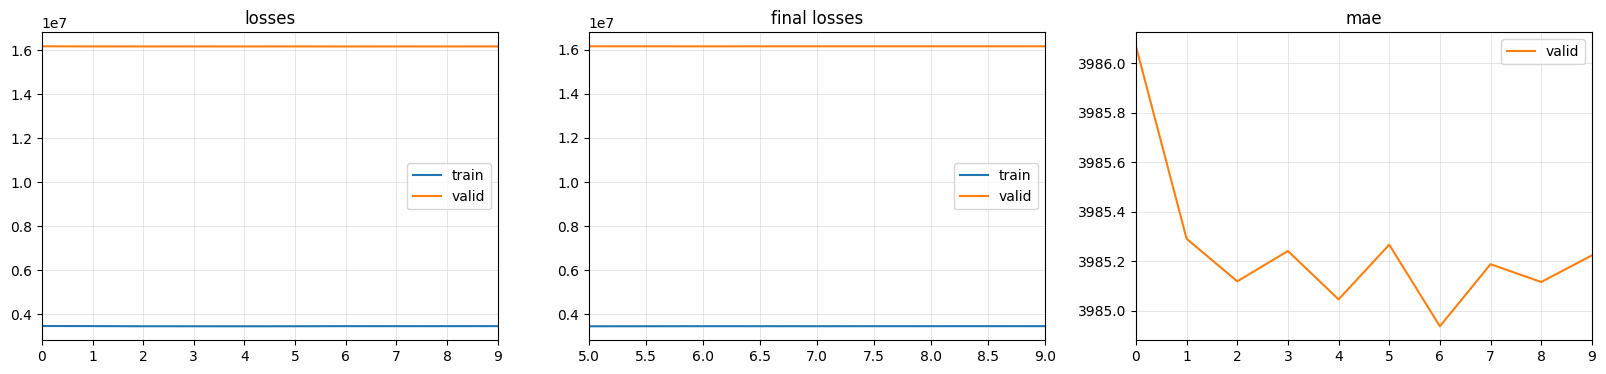

ResCNN


epoch,train_loss,valid_loss,mae,time
0,3444209.250000,16167273.000000,3985.804443,00:00
1,3447843.250000,16090196.000000,3976.413574,00:00
2,3444419.000000,16079867.000000,3975.117676,00:00
3,3440043.250000,16111163.000000,3978.820557,00:00
4,3441514.500000,16128548.000000,3980.883789,00:00
5,3439141.250000,16128925.000000,3980.925781,00:00
6,3437590.750000,16092506.000000,3976.573730,00:00
7,3438121.000000,16105080.000000,3978.024414,00:00
8,3437756.000000,16093636.000000,3976.615723,00:00
9,3440131.000000,16089891.000000,3976.165527,00:00


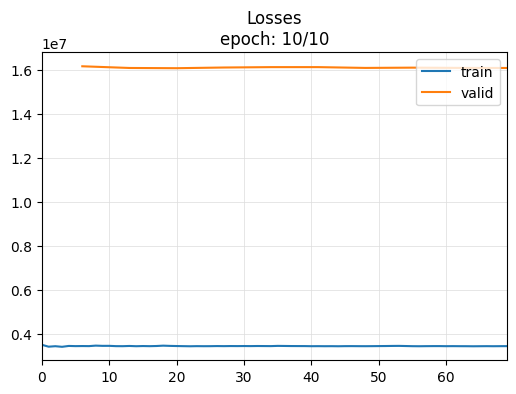

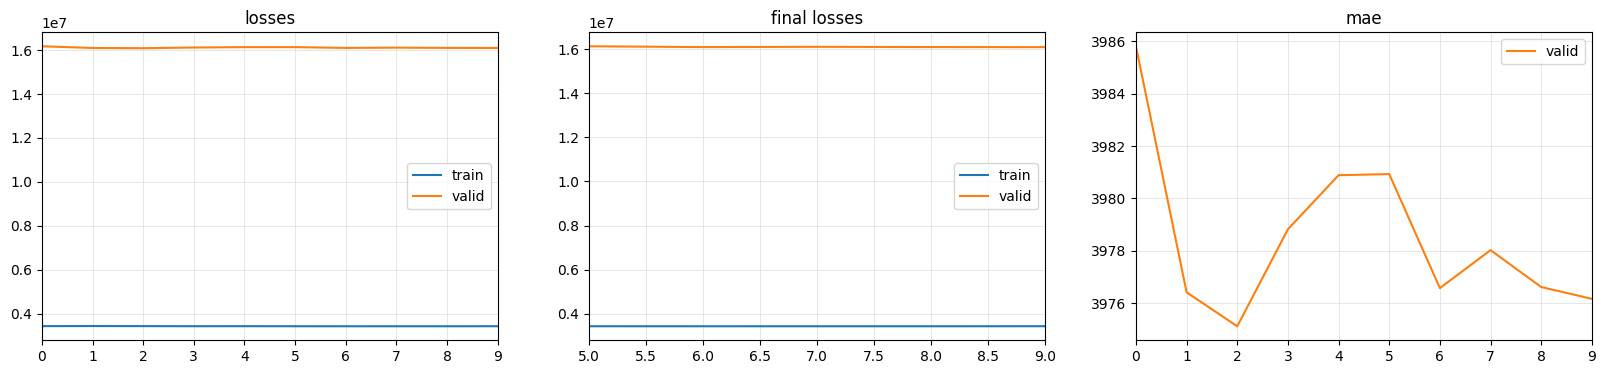

OmniScaleCNN


epoch,train_loss,valid_loss,mae,time
0,3444714.500000,16169596.000000,3986.091064,00:00
1,3445014.750000,16135069.000000,3981.892822,00:00
2,3445078.000000,16087856.000000,3976.123779,00:00
3,3448921.250000,16075653.000000,3974.604492,00:00
4,3449336.500000,16075695.000000,3974.579102,00:00
5,3449753.000000,16069562.000000,3973.811768,00:00
6,3452152.500000,16066294.000000,3973.406738,00:00
7,3453090.500000,16065054.000000,3973.247070,00:00
8,3453335.000000,16063839.000000,3973.094971,00:00
9,3452746.000000,16063685.000000,3973.075195,00:00


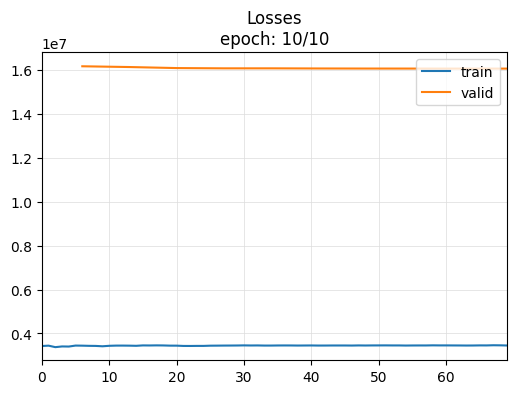

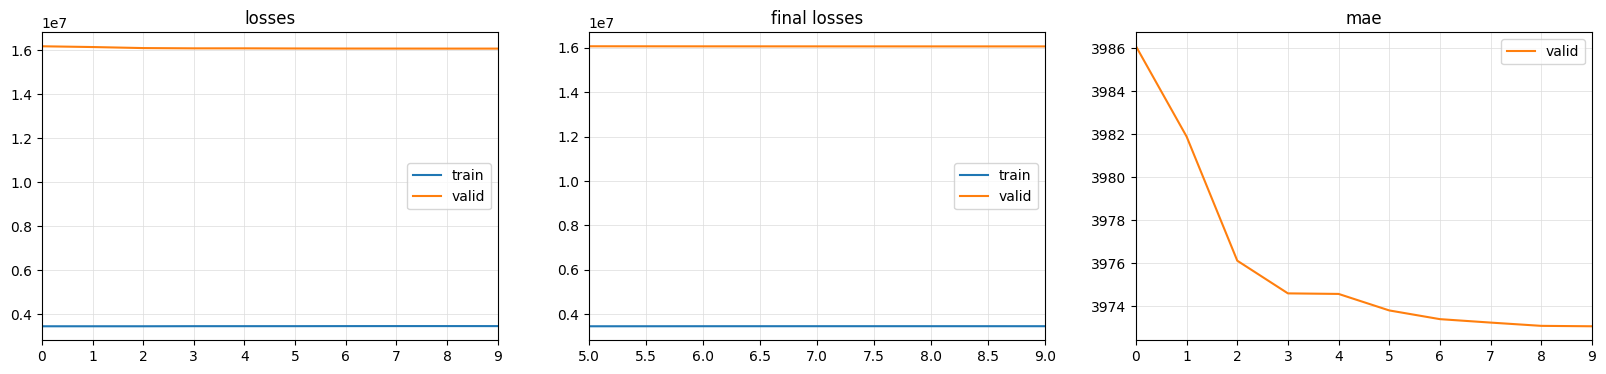

TST


epoch,train_loss,valid_loss,mae,time
0,3432801.500000,16044898.000000,3970.979492,00:01
1,3427925.250000,14164093.000000,3734.716064,00:01
2,3375598.250000,6875490.000000,2615.424805,00:01
3,3281534.500000,8293512.000000,2871.878174,00:01
4,3173441.250000,4579245.000000,2133.271729,00:01
5,3066417.000000,5571645.500000,2355.547119,00:01
6,2964489.500000,6296986.000000,2503.760010,00:01
7,2877307.750000,6925966.500000,2624.455078,00:01
8,2805978.250000,7072517.500000,2651.445557,00:01
9,2748467.750000,7086115.000000,2653.884521,00:01


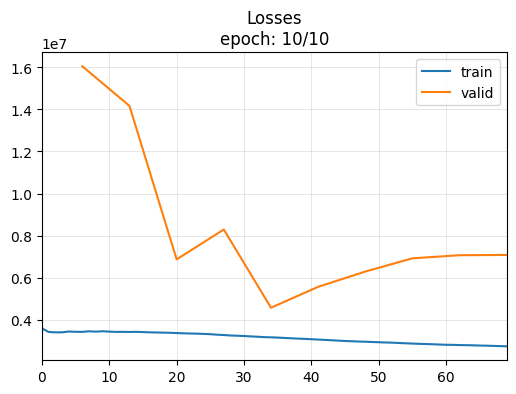

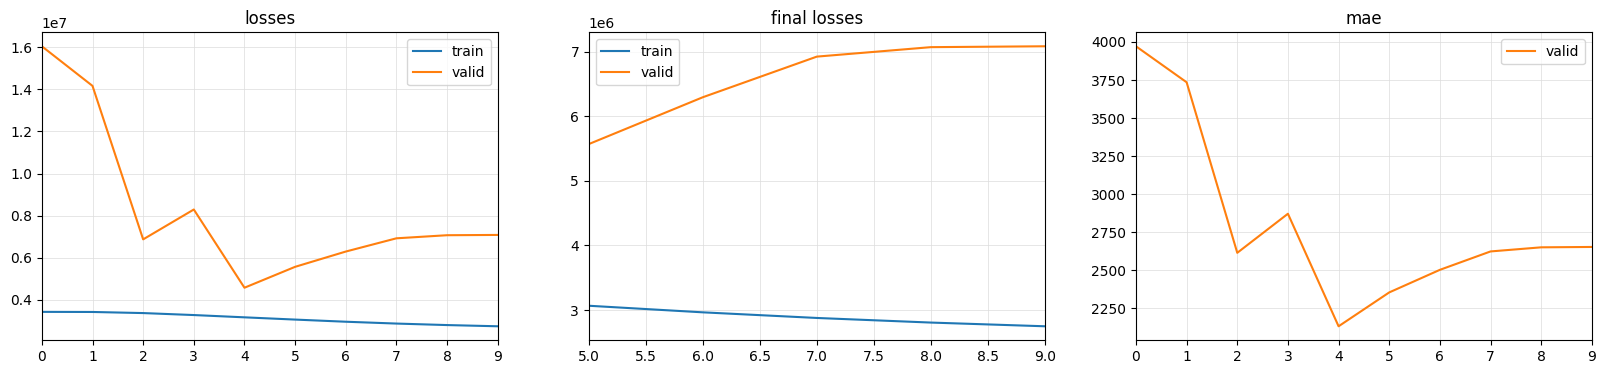

TSTPlus


epoch,train_loss,valid_loss,mae,time
0,3443230.250000,16062871.000000,3973.152344,00:01
1,3439521.250000,15289043.000000,3877.860596,00:01
2,3375432.250000,13294673.000000,3619.970947,00:01
3,3287818.500000,11917855.000000,3429.056641,00:01
4,3181083.750000,11606818.000000,3382.028564,00:01
5,3072740.500000,11375304.000000,3348.825684,00:01
6,2973289.500000,10783730.000000,3262.299316,00:01
7,2885351.250000,9904977.000000,3128.709473,00:01
8,2808357.250000,8892820.000000,2966.727539,00:01
9,2746654.500000,8646580.000000,2925.851318,00:01


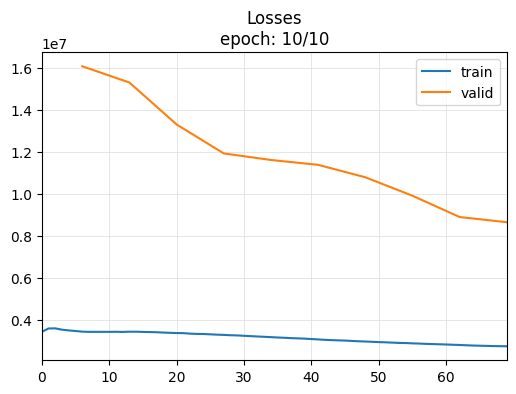

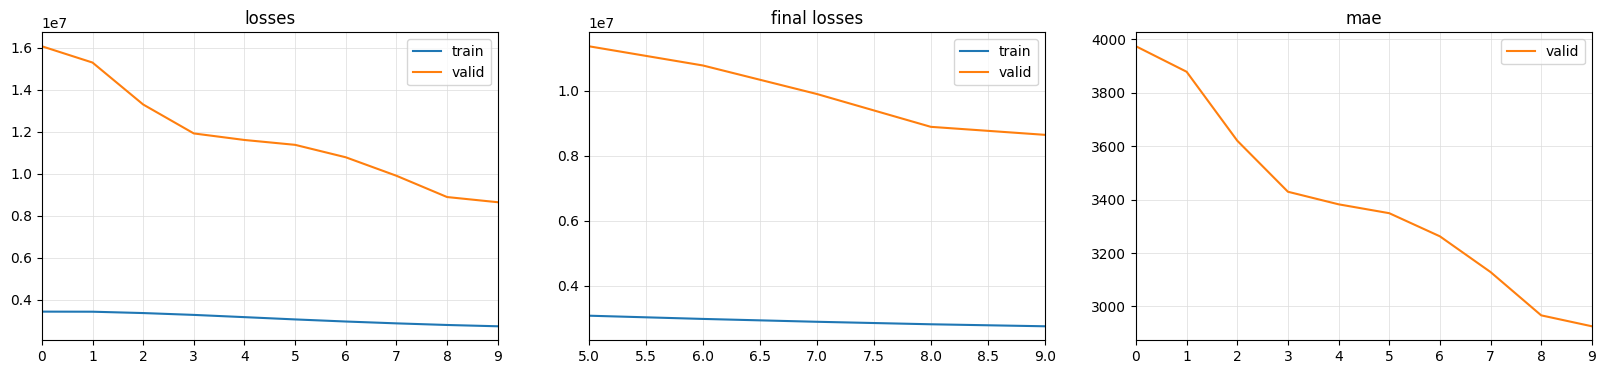

TSiT


epoch,train_loss,valid_loss,mae,time
0,3468025.750000,16165090.000000,3985.453125,00:01
1,3447857.750000,16122363.000000,3980.123047,00:01
2,3447576.000000,16110483.000000,3978.633301,00:01
3,3444274.500000,16097368.000000,3976.984863,00:01
4,3437491.500000,16084873.000000,3975.413330,00:01
5,3432334.250000,16074422.000000,3974.097656,00:01
6,3428813.000000,16066832.000000,3973.141846,00:01
7,3428104.000000,16062367.000000,3972.578857,00:01
8,3425512.000000,16060526.000000,3972.346436,00:01
9,3421553.500000,16060218.000000,3972.307861,00:01


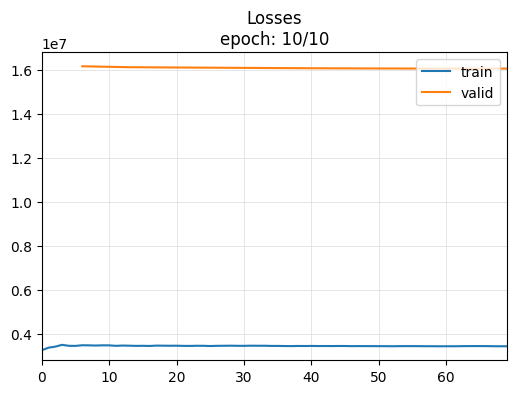

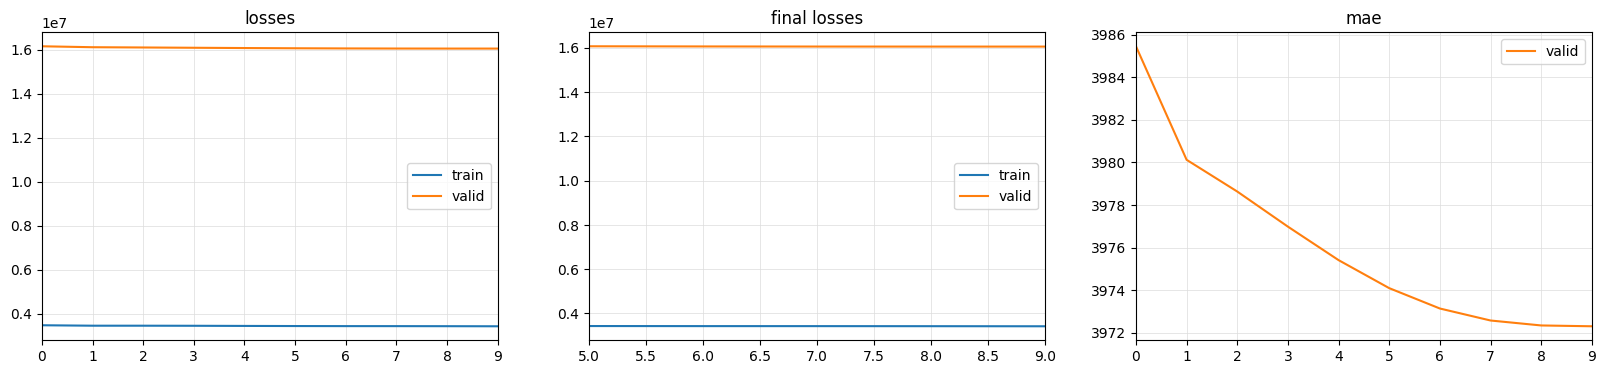

MiniRocket


epoch,train_loss,valid_loss,mae,time
0,3461032.500000,16168947.000000,3985.966553,00:00
1,3451031.500000,16098530.000000,3977.064697,00:00
2,3431135.250000,15878951.000000,3949.173828,00:00
3,3411955.000000,15482196.000000,3898.228271,00:00
4,3397551.250000,14922234.000000,3825.047363,00:00
5,3382340.250000,14264644.000000,3737.070068,00:00
6,3360282.000000,13616358.000000,3648.006592,00:00
7,3344036.000000,13104446.000000,3575.795654,00:00
8,3331049.000000,12745987.000000,3524.022217,00:00
9,3320316.000000,12526454.000000,3491.531006,00:00


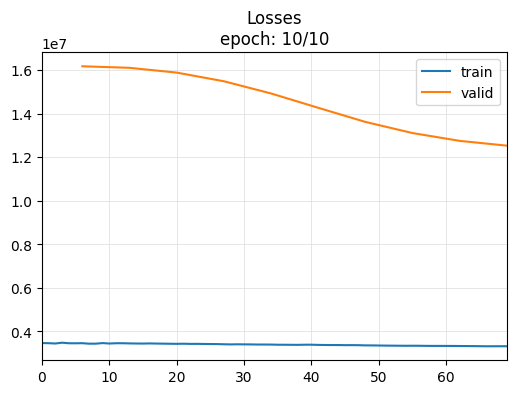

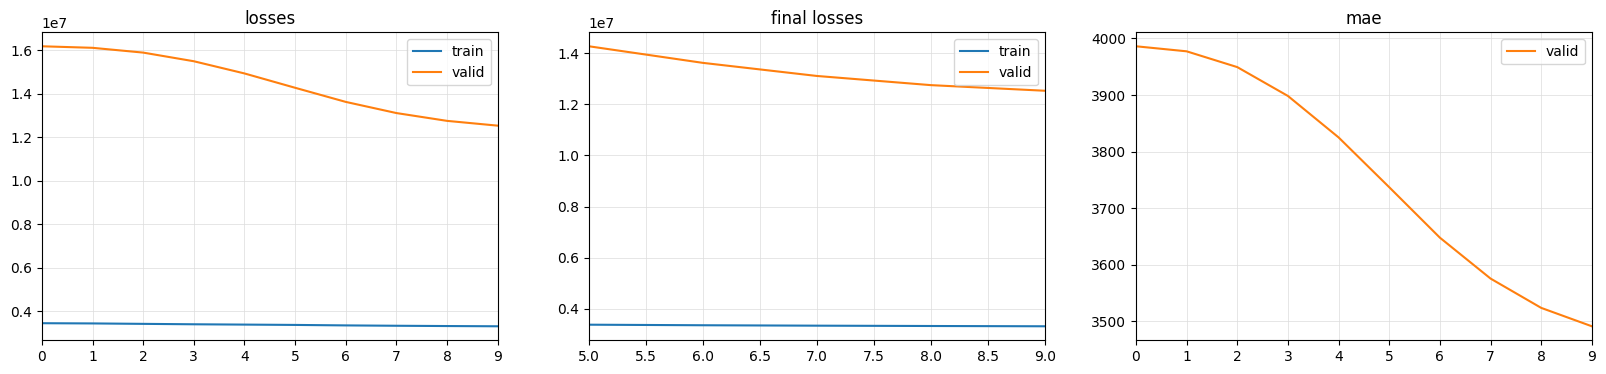

XCM


epoch,train_loss,valid_loss,mae,time
0,3436988.250000,16177292.000000,3987.022461,00:00
1,3453974.250000,16173462.000000,3986.541992,00:00
2,3446060.750000,16164987.000000,3985.479004,00:00
3,3442977.500000,16158127.000000,3984.618164,00:00
4,3444799.750000,16153042.000000,3983.979980,00:00
5,3444826.500000,16149611.000000,3983.549316,00:00
6,3444261.000000,16148855.000000,3983.454590,00:00
7,3443617.000000,16148186.000000,3983.370361,00:00
8,3446606.250000,16145728.000000,3983.061768,00:00
9,3448188.500000,16143534.000000,3982.786377,00:00


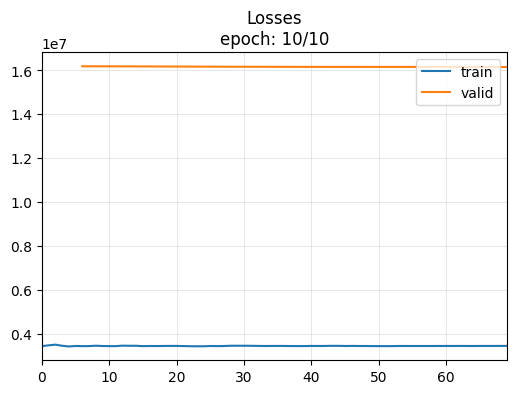

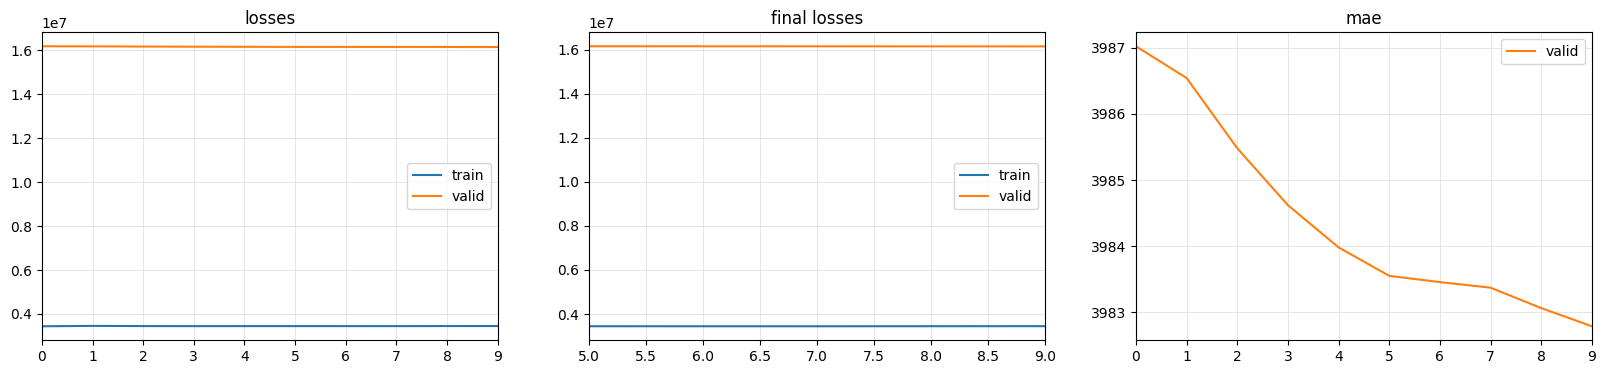

gMLP


epoch,train_loss,valid_loss,mae,time
0,3447514.500000,16130131.000000,3981.064209,00:01
1,3408765.250000,15486617.000000,3899.106934,00:01
2,2973090.500000,8128511.500000,2800.117432,00:01
3,2202301.250000,5492857.000000,2279.708740,00:01
4,1670497.250000,2033144.500000,1313.866089,00:01
5,1299437.625000,2188873.750000,1383.245117,00:01
6,1033077.562500,1993247.875000,1316.281860,00:01
7,835845.312500,1644237.750000,1175.530396,00:01
8,685208.875000,1533568.375000,1126.910278,00:01
9,568047.625000,1519662.750000,1120.730103,00:01


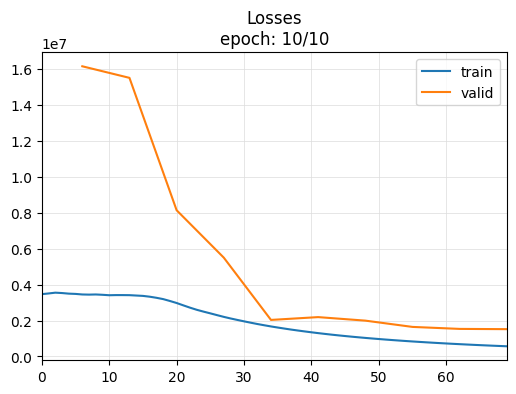

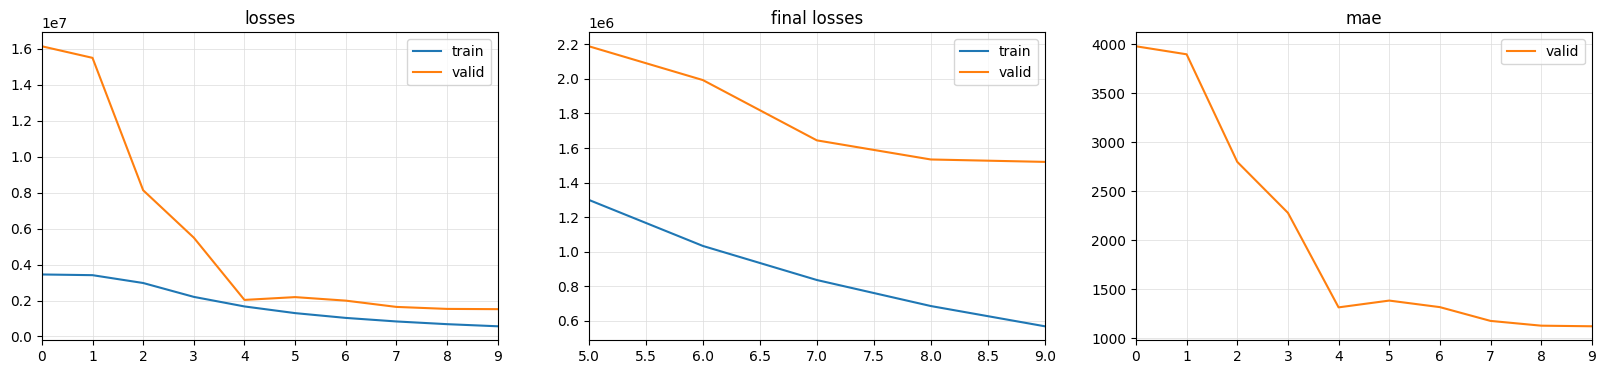

TSSequencerPlus


epoch,train_loss,valid_loss,mae,time
0,3435984.500000,16166884.000000,3985.703125,00:02
1,3448378.250000,16133136.000000,3981.450684,00:02
2,3439036.000000,16088325.000000,3975.811279,00:02
3,3427767.250000,16051423.000000,3971.164307,00:02
4,3415879.000000,16024321.000000,3967.749023,00:02
5,3407158.750000,16002694.000000,3964.998535,00:02
6,3395894.000000,15986299.000000,3962.925781,00:02
7,3387957.000000,15975171.000000,3961.523193,00:02
8,3383069.500000,15971044.000000,3961.003662,00:02
9,3374837.750000,15970379.000000,3960.919922,00:02


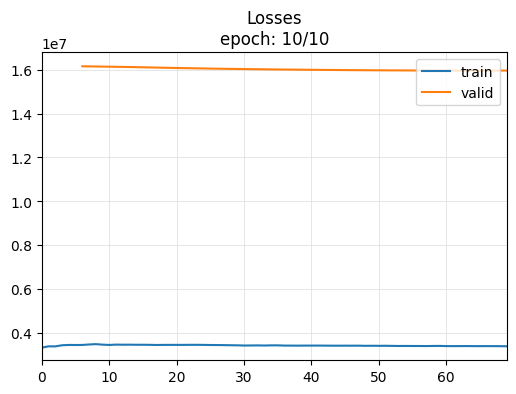

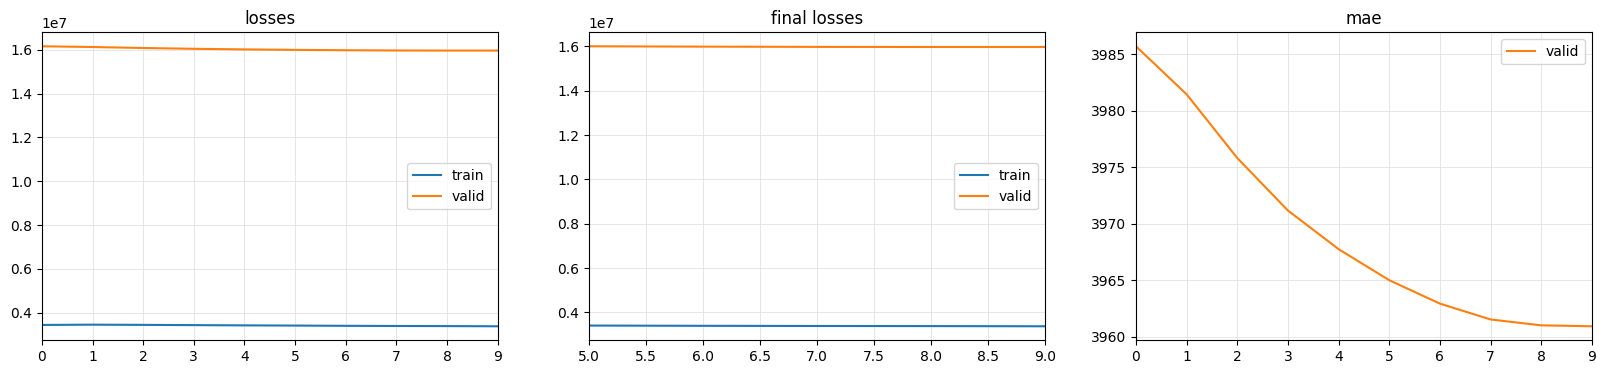

In [14]:
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()
for arch in archs[10:]:
    print(arch)
    fcst = TSForecaster(X, y, splits=splits, path='models/', tfms=tfms, batch_tfms=batch_tfms, bs=512, 
                        arch=arch, metrics=mae, cbs=ShowGraph())
    fcst.fit_one_cycle(5, 1e-3)
#     fcst.export("stonk.pkl")
#     fcst = load_learner("models/stonk.pkl", cpu=False)

#     results = {
#         "train": predict(fcst, X, y, splits[0]),
#         "val": predict(fcst, X, y, splits[1]),
#         "test": predict(fcst, X, y, splits[2]),
#     }

In [ ]:
results['test']

In [ ]:
evaluate(results['val']['target'], results['val']['raw_preds'])

In [ ]:
evaluate(results['test']['target'], results['test']['raw_preds'])

In [ ]:
df_out = pd.concat((results['train'], results['val'], results['test']))[["target", "raw_preds"]]

df_out.index = gspc_hist[window_len:].index
df_out

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

In [ ]:
fig = px.line(df_out, labels={'value': "Open", 'created_at': 'Date'})
fig.add_vline(x=val_date, line_width=4, line_dash="dash")
fig.add_vline(x=test_date, line_width=4, line_dash="dash")
# fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [ ]:
def buy_sell_stock(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(1, len(prices)-1):
        if  holding and prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [ ]:
def buy_sell_stock_v2(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [ ]:
def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    # plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns = \
buy_sell_stock(results['test']['raw_preds'], results['test']['target'])
print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")
plot_stock_prices(results['test']['raw_preds'], results['test']['target'], buy_days, sell_days)